In [0]:
import pandas as pd
import numpy as np
import math
import tensorflow as tf
from tensorflow.python.framework import ops
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt 
from sklearn.utils import shuffle


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks")


In [0]:
!ls

 digit_using_cnn.ipynb			   'Simple CNN Image Tutorial'
 fashion_mnist_keras.ipynb		    test.csv
 Handwriten_keras.ipynb			    train.csv
 mnist_data_download_digit.ipynb	    Untitled0.ipynb
 Mnist_handwriting_using_tensorflow.ipynb   Untitled2.ipynb


In [0]:
train =pd.read_csv("train.csv")

In [0]:
X = np.array(train.drop(['label'],axis = 1))
Y = np.array(train['label'])
X = X.reshape((-1 , 28 , 28 , 1))   #################### to reshape the data 

X_Train , X_Test , Y_train , Y_test = train_test_split(X , Y , test_size = .2)
X.shape

(42000, 28, 28, 1)

In [0]:
def one_hot_matrix(labels , C ):
    C = tf.constant(C , name = "C")
    one_hot_matrix = tf.one_hot(labels , C , axis = 0)
    sess = tf.Session()
    one_hot = sess.run(one_hot_matrix)
    sess.close()
    return one_hot

In [0]:
Y_train = one_hot_matrix(Y_train,C = 10)  # change into one_hot_matrix
Y_test = one_hot_matrix(Y_test,C = 10)
print(Y_train[0])

[0. 0. 0. ... 0. 1. 0.]


In [0]:
# make X_train shape to 784* 60000 and normalize it
X_train = X_Train.T/255
X_test = X_Test.T/255 
print(X_train.shape,X_test.shape)

m = X_train.shape[1]
n_x =X_train.shape[0]
n_y = Y_train.shape[0]

(1, 28, 28, 33600) (1, 28, 28, 8400)


In [0]:
# GRADED FUNCTION: create_placeholders

def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    ### START CODE HERE ### (≈2 lines)
    X = tf.placeholder(tf.float32,[None,n_H0,n_W0,n_C0],name ="X")
    Y = tf.placeholder(tf.float32,[None,n_y],name = "Y")
    ### END CODE HERE ###
    
    return X, Y

In [0]:
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)                            # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 2 lines of code)
    W1 = tf.get_variable("W1",[8,8,1,16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2",[8,8,16,32], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
    W3 = tf.get_variable("W3",[2,2,16,32], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "W2": W2,
                  "W3": W3 }
    
    return parameters

In [0]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']    
    ### START CODE HERE ###
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1,strides = [1,1,1,1],padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1,ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2,strides = [1,1,1,1],padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2,ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    
    #//Z3 = tf.nn.conv2d(P2,W3,strides = [1,1,1,1],padding = 'SAME')

    
    #//A3 = tf.nn.relu(Z3)
    
    #//P3 = tf.nn.max_pool(A3,ksize = [1,4,4,1],strides = [1,4,4,1],padding = 'SAME')
    
    # FLATTEN
    P3 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P3, 10,activation_fn = None)
    ### END CODE HERE ###

    return Z3

In [0]:

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):

    m = X.shape[0]                  
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [0]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))
    #cost = tf.reduce_mean(cost)
    ### END CODE HERE ###
    
    return cost

In [0]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y) 
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , temp_cost = sess.run([optimizer,cost], feed_dict = {X:minibatch_X,Y:minibatch_Y})
                ### END CODE HERE ###
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 0.219112
Cost after epoch 5: 0.051462
Cost after epoch 10: 0.044752
Cost after epoch 15: 0.037981
Cost after epoch 20: 0.042569
Cost after epoch 25: 0.038129
Cost after epoch 30: 0.034925
Cost after epoch 35: 0.041922
Cost after epoch 40: 0.048311
Cost after epoch 45: 0.028496
Cost after epoch 50: 0.041896
Cost after epoch 55: 0.051716
Cost after epoch 60: 0.038514
Cost after epoch 65: 0.019889
Cost after epoch 70: 0.038523
Cost after epoch 75: 0.038637
Cost after epoch 80: 0.032660
Cost after epoch 85: 0.035562
Cost after epoch 90: 0.037100
Cost after epoch 95: 0.043897


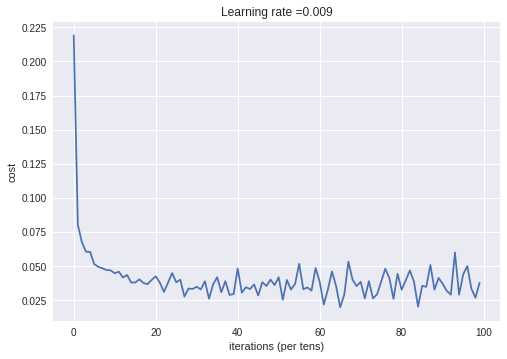

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.99642855
Test Accuracy: 0.9822619


In [0]:
_, _, parameters = model(X_train.T, Y_train.T, X_test.T, Y_test.T)  #############tranpose of all is taken